# Introduction

In the last exercises, you implemented different networks for image classification on the CIFAR10 Dataset.
For this exercise you will work on pixelwise segmentation (think: classification per pixel instead of per image). 
There are multiple types of segmentation, the most prominent ones are semantic segmentation and instance segmentation.
The goal of semantic segmentation is to assign to each pixel a class (e.g. car, bike), whereas the goal of instance segmentation is to assign to each pixel some object id.
This can also be combined to e.g. extract all individual cars from an image (semantic instance segmentation).

## General Information

**Workflow** For this assignment you need a GPU. If you have one, you can keep on working locally with this notebook. If not, we recommend to use colab. If both options do not work for you, please let us know.

**Assignment submission** You need to submit both this notebook and the model(s) you've trained. If the model is small enough you can submit it via moodle, otherwise upload it e.g. on google drive or firefox send and submit a text file with the link to it.

## How to setup Google Colab

You already know about colab from the previous exercises. Here are the most important infos again:

**Requirements** To use Colab, you must have a Google account with an associated Google Drive.

**Reminder** Ressources on colab are not guaranteed and therefore there might be times where some ressources cannot get allocated. If you're idle for 90 minutes or your connection time exceeds the maximum of 12 hours, the colab virtual machine will disconnect. This means that unsaved progress such as model parameters are lost.

**Upload the data**
You need to upload your data on the remote machine. Make sure to upload the zip and not the extracted data, this is significantly faster. There are two primary options:  
You can upload the data directly into colab (Click on the Files icon on the left side and then on upload). This is the most straightforward way, but you have to do it every time you start a new colab session.  
The second option is to use Google Drive and import the data from there into Colab. 
First, you need to upload the provided zip file (data.zip) to your Google Drive. Next, you mount your Google Drive on the remote machine. In order to do so, you can use the cell below.  
In all case you then have to execute the "extract data" cell to unpack the zip file (You might have to change the path_to_zip variable).  
Use the "verify" cell to make sure that the data is accessible.

In [3]:
# ### mount your google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # add your local project folder to be able to import all utils files
# import os
# path = "/content/drive/My Drive/Colab Notebooks/sose22" # change this to your local project folder
# os.chdir(path)
vyvy_colab=False

if vyvy_colab:
    # ### mount your google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # # add your local project folder to be able to import all utils files
    import os
    path = "/content/drive/My Drive/Uni/Master/2.Sem/MLIA/exercise_6" # change this to your local project folder
    os.chdir(path)
    path_to_zip = "data.zip"
    #!unzip $path_to_zip
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [4]:
#path_to_zip = "data.zip"

In [5]:
# !unzip $path_to_zip

In [6]:
# verify that the data is found
import glob
fls = glob.glob(os.path.join("dsb2018", "train", "*.zarr"))
print(len(fls), fls[:5])

30 ['dsb2018\\train\\02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339.zarr', 'dsb2018\\train\\0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275.zarr', 'dsb2018\\train\\08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada.zarr', 'dsb2018\\train\\1023509cf8d4c155467800f89508690be9513431992f470594281cd37dbd020d.zarr', 'dsb2018\\train\\10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.zarr']


## Grading

This exercise counts 30% towards your total score.
You can get a maximum of 100 points.

| Section | Part | Task | Points |
|------|----------------------------------------|-------------|-------------|
| 1 | Data Loader | Augmentation                             | 10          |
| 2 | U-Net | Implementation           | 30          |
| 3 | Foreground/Background Segmentation | Calculate accuracy   | 5          |
|  | | Call train        | 5          |
| 4 |Receptive Field| Implementation                       | 10          |
| ||Question 1                                            | 5          |
| 5 | Instance Segmentation | Define losses   | 10          |
| || Define U-Net                                |  5          | 
| || Call train                                |  5          | 
| ||Benchmark                                            | 10          |
| ||Question 2                                            |5          |
| |Total Points|                                            | 100          |

## Install and import packages

In [7]:
if vyvy_colab:
    !pip uninstall albumentations -y
    !pip install numpy pillow matplotlib scikit-image zarr imgaug==0.4.0 torchsummary tensorboard mahotas

In [8]:
%matplotlib inline
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from __future__ import division, print_function
import glob
import zarr
import random
import datetime
import numpy as np
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from imgaug.augmentables.heatmaps import HeatmapsOnImage

from skimage import io
from utils.colormap import *
from utils.mean_shift import MeanShift

plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

C:\Users\Dennis Naujokat\AppData\Local\Temp\ipykernel_3548\239437587.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Data
For this task we use a subset of the data used in the kaggle data science bowl 2018 challenge (https://www.kaggle.com/c/data-science-bowl-2018/).

Example image:

![kaggle_example](https://data.broadinstitute.org/bbbc/BBBC038/BBBC038exampleimage1.png)

All images show nuclei recorded using different microscopes and lighting conditions. There are 30 images in the training set, 8 in the validation set and 16 in the test set.

Visualize the data:

In [9]:
# utility functions to visualize data

def plot_image(raw, labels, pred=None):
    fig=plt.figure(figsize=(12, 8))
    if pred is not None:
        num_plots = 3
    else:
        num_plots = 2
    fig.add_subplot(1, num_plots, 1)
    plt.imshow(np.squeeze(raw), cmap='gray')
    fig.add_subplot(1, num_plots, 2)
    plt.imshow(np.squeeze(labels), cmap='gist_earth')
    if pred is not None:
        fig.add_subplot(1, num_plots, 3)
        plt.imshow(np.squeeze(pred), cmap='gist_earth')
    
def plot_random_image():
    fls = glob.glob(os.path.join("dsb2018", "train", "*.zarr"))
    fl = zarr.open(fls[random.randrange(len(fls))], 'r')
    raw = fl["volumes/raw"]
    labels = fl["volumes/gt_threeclass"]
    plot_image(raw, labels)

Execute the next cell repeatedly to have a look at the data. 
We start with the foreground/background segmentation. So the ground truth has 2 labels: Background is zero and cell is one.

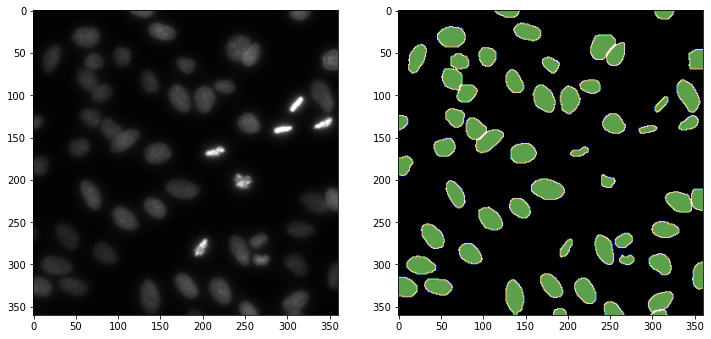

In [10]:
# repeatedly execute this cell to get different images
plot_random_image()

## Load the data

Here we implement a custom dataset for the kaggle data. For more information, you can look here:
https://pytorch.org/docs/stable/data.html
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### todo: Augmentation

Especially when the size of the dataset is limited, data augmentation is essential to get good results.
Extend your data loader to augment your data during training on the fly.
Think about what kind of augmentation to use (e.g. flips, rotation, elastic) and if you might need to pad or crop your data.

We have prepared the code to use the external data augmentation library imgaug (https://imgaug.readthedocs.io/en/latest/), but you are free to change the code to implement the data augmentation differently when you like (e.g. using numpy or torchvision.transfom functions).

In [11]:
class KaggleDSB_dataset(Dataset):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the torch dataset class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.
    Args:
        root_dir (string): Directory with all the images.
        mode (string): train/val/test, select subset of images
        prediction_type (string): default to be "metric_learning" for this notebook
        net_input_size (list): the input title size of you UNet
        padding_size (int): the number of pixels to pad on each side of the image before augmentation and cropping
        cache: if cache the data, default: False
    """
    def __init__(self,
                 root_dir,
                 mode,
                 prediction_type="two_class",
                 net_input_size=None,
                 padding_size=None
                ):
        self.mode = mode
        self.files = glob.glob(os.path.join(root_dir, mode, "*.zarr"))
        self.prediction_type = prediction_type
        self.net_input_size = net_input_size
        self.padding_size = padding_size
        self.define_augmentation()

    def __len__(self):
        return len(self.files)
    
    def define_augmentation(self):
        
        self.transform = iaa.Identity
        self.crop = None
        self.pad = None

        ###########################################################################
        # TODO: Define your augmentation pipeline and uncomment the    #
        # following code                                                          #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # define self.transfrom by looking into the imgaug package reference
        
        self.transform = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            iaa.Crop(percent=(0, 0.1)), # random crops
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(
                0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.LinearContrast((0.75, 1.5)),
            # Add gaussian noise.
            # For 50% of all images, we sample the noise once per pixel.
            # For the other 50% of all images, we sample the noise per pixel AND
            # channel. This can change the color (not only brightness) of the
            # pixels.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-25, 25),
                shear=(-8, 8)
            )
        ], random_order=True) # apply augmenters in random order
        
        
        if self.net_input_size is not None:
            self.crop = iaa.CropToFixedSize(self.net_input_size)

        if self.padding_size is not None:
            self.pad =  iaa.Pad(px=self.padding_size)
            
            
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def get_filename(self, idx):
        return self.files[idx]
        
    def __getitem__(self, idx):
        fn = self.get_filename(idx)
        raw, label = self.load_sample(fn)
        raw = self.normalize(raw)
        # augment for training
        if self.padding_size is not None:
            raw = self.pad(images = raw) # CHW -> CHW
            label = self.pad(images = label) # CHW -> CHW
        if self.mode == "train":
            raw = np.transpose(raw, [1,2,0]) # CHW -> HWC
            label = np.transpose(label, [1,2,0]) # CHW -> HWC            
            raw, label = self.augment_sample(raw, label) # HWC -> HWC
            raw = np.transpose(raw, [2,0,1]) # HWC -> CHW
            label = np.transpose(label, [2,0,1]) # HWC -> CHW
        if self.net_input_size is not None:
            tmp = np.concatenate([raw, label], axis = 0).copy() # C1+C2 HW
            tmp = np.transpose(tmp, [1,2,0]) # CHW -> HWC 
            tmp = self.crop.augment_image(tmp) # HWC -> HWC
            tmp = np.transpose(tmp, [2,0,1])
            raw, label = np.expand_dims(tmp[0], axis=0), np.stack(tmp[1:],axis=0) # split
        raw, label = torch.tensor(raw), torch.tensor(label)
        return raw, label
    
    def augment_sample(self, raw, label):
        # stores float label (sdt) differently than integer label (rest)
        if self.prediction_type in ["sdt"]:
            label = HeatmapsOnImage(label, shape=raw.shape, min_value=-1.0, max_value=1.0)
            raw, label = self.transform(image=raw, heatmaps=label)
        else:
            label = label.astype(np.int32)
            label = SegmentationMapsOnImage(label, shape=raw.shape)
            raw, label = self.transform(image=raw, segmentation_maps=label)
            
        label = label.get_arr() 
        # some pytorch version have problems with negative indices introduced by e.g. flips
        # just copying fixes this
        label = label.copy()
        raw = raw.copy()
        return raw, label
    
    def normalize(self, raw):
        # z-normalization
        raw -= np.mean(raw)
        raw /= np.std(raw)
        return raw
    
    def load_sample(self, filename):
        data = zarr.open(filename)
        raw = np.array(data['volumes/raw'])
        if self.prediction_type == "two_class":
            label = np.array(data['volumes/gt_fgbg'])
        elif self.prediction_type == "three_class":
            label = np.array(data['volumes/gt_threeclass'])
        elif self.prediction_type == "affinities":
            label = np.array(data['volumes/gt_affs'])
        elif self.prediction_type == "sdt":
            label = np.array(data['volumes/gt_tanh'])
        elif self.prediction_type == "metric_learning":
            label = np.array(data['volumes/gt_labels'])
        label = label.astype(np.float32)
        return raw, label

### Check the data loader
Look at the training data to see if your dataset and data loader are working and,
if you are using augmentation, if the augmentation looks reasonable.

In [12]:
dataset = "dsb2018"
prediction_type = "two_class"
num_fmaps_out = 2

tmp_data = KaggleDSB_dataset(dataset,  mode="train", prediction_type=prediction_type)
tmp_loader = DataLoader(tmp_data, batch_size=1, shuffle=True)

dataiter = iter(tmp_loader)

torch.Size([1, 1, 360, 360]) torch.Size([1, 1, 360, 360])


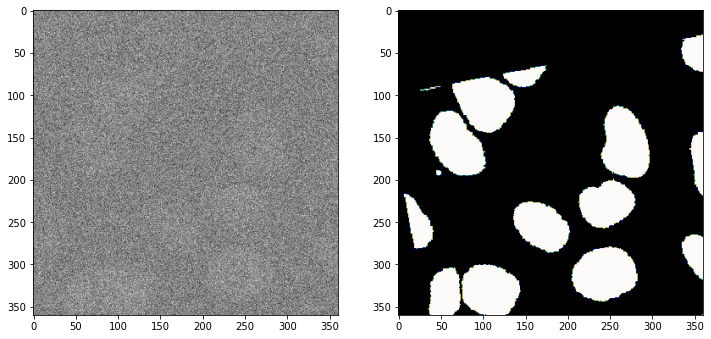

In [13]:
# repeatedly execute this cell
image, label = next(dataiter)
print(image.shape, label.shape)
plot_image(image, label)

# U-Net

The network you will use is a so-call U-Net. Your task is to implement it and use it to segment the dataset described above.
The U-Net is a popular core architecture for segmentation and extensively used for medical and biological data.

![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Start by reading the paper: [U-Net: Convolutional Networks for BiomedicalImage Segmentation](https://arxiv.org/pdf/1505.04597.pdf). It has been hugely influential in the field and it is very concise and understandable.
We recommend asking your colleagues on the moodle forums with respect to unclear aspects of the architecture.
(If that does not solve it, there are also a number of tutorials online).

## todo: Implementation

Your main task is to implement a U-Net yourselves. 
(Disclaimer: We are aware that there are a number of implementations out there, but we **strongly recommend** to not look at them before trying it yourselves, this is a very fundamental exercise, and the knowledge you gain will be very helpful to you if you try to implement other architectures, and you learn significantly more by trying it yourselves than by looking at other people's code.
The implementation is not completely straight forward. If you are stuck, ask in the forum or check out one of the tutorials online.
Feel free to look at the implementations **after** you have a working version and get results on the data.
It might be a helpful exercise to check what they maybe have done better and what you maybe have done better.
Yet there is no need to change your implementation, there are no extra points for the most elegant or efficient solution).

**Padding:** You can either use valid or same padding for your convolutions.

**Upsampling**: Pytorch has modules for upsampling and transposed convolutions. Choose whatever you like to try out.

In [14]:
DEBUG = False

class UNet(torch.nn.Module):

    def __init__(
            self,
            in_channels,
            num_fmaps,
            fmap_inc_factors,
            downsample_factors,
            kernel_size_down=None,
            kernel_size_up=None,
            activation='ReLU',
            padding='VALID', # might not be needed
            num_fmaps_out=None,
            constant_upsample=True # might not be needed
            ):
        '''Create a U-Net::

            f_in --> f_left --------------------------->> f_right--> f_out
                        |                                   ^
                        v                                   |
                     g_in --> g_left ------->> g_right --> g_out
                                 |               ^
                                 v               |
                                       ...

        where each ``-->`` is a convolution pass, each `-->>` a crop, and down
        and up arrows are max-pooling and transposed convolutions,
        respectively.

        The U-Net expects 2D tensors shaped like::

            ``(batch=1, channels, height, width)``.

        This U-Net performs only "valid" convolutions, i.e., sizes of the
        feature maps decrease after each convolution.

        Args:

            in_channels:

                The number of input channels.

            num_fmaps:

                The number of feature maps in the first layer. This is also the
                number of output feature maps. Stored in the ``channels``
                dimension.

            fmap_inc_factors:

                By how much to multiply the number of feature maps between
                layers. If layer 0 has ``k`` feature maps, layer ``l`` will
                have ``k*fmap_inc_factor**l``.

            downsample_factors:

                List of tuples ``(y, x)`` to use to down- and up-sample the
                feature maps between layers.

            kernel_size_down (optional):

                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the left side. Kernel sizes
                can be given as tuples or integer. If not given, each
                convolutional pass will consist of two 3x3 convolutions.

            kernel_size_up (optional):

                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the right side. Within one
                of the lists going from left to right. Kernel sizes can be
                given as tuples or integer. If not given, each convolutional
                pass will consist of two 3x3 convolutions.

            activation:

                Which activation to use after a convolution. Accepts the name
                of any tensorflow activation function (e.g., ``ReLU`` for
                ``torch.nn.ReLU``).

            fov (optional):

                Initial field of view


            constant_upsample (optional):

                If set to true, perform a constant upsampling instead of a
                transposed convolution in the upsampling layers.
        '''

        super(UNet, self).__init__()

        self.num_levels = len(downsample_factors) + 1
        self.in_channels = in_channels
        self.out_channels = num_fmaps_out if num_fmaps_out else num_fmaps
        self.constant_upsample = constant_upsample

        # default arguments
        if kernel_size_down is None:
            kernel_size_down = [[(3, 3), (3, 3)]]*self.num_levels
        if kernel_size_up is None:
            kernel_size_up = [[(3, 3), (3, 3)]]*(self.num_levels - 1)
            
        self.kernel_size_down = kernel_size_down
        self.kernel_size_up = kernel_size_up
        self.downsample_factors = downsample_factors

        ########################################################################
        # TODO:                                                                #
        # - Implement your U-Net class here                                    #
        # - (later) Add a function to compute its receptive field              #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        print(f'init connection layer: {self.num_levels - 1}') if DEBUG else 0
        in_size = num_fmaps * fmap_inc_factors**(self.num_levels - 1)
        features = in_size * fmap_inc_factors
        kernals = kernel_size_down[-1]
        last_layer = LastConv(in_size, features, kernals, activation)

        for layer in range(self.num_levels-2, -1, -1):
            print(f'init layer: {layer}') if DEBUG else 0
            features = in_size
            in_size = num_fmaps * fmap_inc_factors**layer
            kernals_left = kernel_size_down[layer]
            kernals_rigth = kernel_size_up[layer]
            kernals_down, kernals_up = downsample_factors[layer]

            if layer == 0: # layer 0
                in_size = in_channels

            last_layer = UNetLayer(
                in_channels=in_size, 
                featuers=features, 
                left_kernals=kernals_left, 
                rigth_kernals=kernals_rigth, 
                down_kernel=kernals_down, 
                up_kernel=kernals_up, 
                activation=activation, 
                betweenModule=last_layer)

        self.unetLayer = last_layer
        self.end_conv = nn.Conv2d(features, self.out_channels, 1)

        
    def forward(self, x):
        befor_last_conv = self.unetLayer(x)
        after_last_conv = self.end_conv(befor_last_conv)
        return after_last_conv

    def calcRespectiveField(self):
        rf = self.unetLayer.calcRespectiveField()
        return rf

class UNetLayer(torch.nn.Module):
    def __init__(self, in_channels, featuers, left_kernals, rigth_kernals, down_kernel, up_kernel, activation, betweenModule: torch.nn.Module):
        super(UNetLayer, self).__init__()

        self.down_kernel = down_kernel

        self.conv_left = MultiConv(in_channels, featuers, left_kernals, activation)
        self.down = nn.MaxPool2d(down_kernel)
        self.between = betweenModule
        self.up = nn.ConvTranspose2d(2*featuers, featuers, kernel_size=up_kernel, stride=2)
        self.conv_rigth = MultiConv(2*featuers, featuers, rigth_kernals, activation)

    def forward(self, f_in):
        f_left = self.conv_left(f_in)
        g_in = self.down(f_left)
        g_out = self.between(g_in)
        f_rigth_part_down = self.up(g_out)
        _,_,H,W = f_rigth_part_down.size()
        f_rigth_part_left = torchvision.transforms.CenterCrop([H,W])(f_left)
        f_rigth = torch.concat([f_rigth_part_left, f_rigth_part_down], dim=1)
        f_out = self.conv_rigth(f_rigth)
        return f_out

    def calcRespectiveField(self):
        rf = self.between.calcRespectiveField()
        rf *= self.down_kernel
        rf += self.conv_left.calcRespectiveField()
        return rf

class MultiConv(torch.nn.Module):
    def __init__(self, in_channels, featuers, kernals, activation):
        super(MultiConv, self).__init__()

        self.in_channels = in_channels
        self.featuers = featuers
        self.kernals = kernals
        self.activation = activation

        conv_arr = []
        for idx, kernal in enumerate(kernals):
            conv_arr.append(nn.Conv2d(in_channels if idx == 0 else featuers, featuers, kernel_size=kernal))
            if activation == 'ReLU':
                conv_arr.append(nn.ReLU())

        self.conv = nn.Sequential(*conv_arr)

    def forward(self, x):
        return self.conv(x)

    def calcRespectiveField(self):
        rf = 1
        for kernal in self.kernals:
            rf += kernal[0] -1
        return rf

class LastConv(torch.nn.Module):
    def __init__(self, in_channels, featuers, kernals, activation):
        super(LastConv, self).__init__()

        self.in_channels = in_channels
        self.featuers = featuers
        self.kernals = kernals
        self.activation = activation

        conv_arr = []
        for idx, kernal in enumerate(kernals):
            conv_arr.append(nn.Conv2d(
                in_channels= in_channels if idx == 0 else featuers, 
                out_channels= featuers, 
                kernel_size= kernal, 
            ))
            if activation == 'ReLU':
                conv_arr.append(nn.ReLU())

        self.conv = nn.Sequential(*conv_arr)

    def forward(self, x):
        return self.conv(x)

    def calcRespectiveField(self):
        rf = 1
        for kernal in self.kernals:
            rf += kernal[0] -1
        return rf



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Foreground Segmentation
Define your model for foreground/background segmentation and print out your network summary.

In [15]:
# set seed
torch.manual_seed(42)

# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same', # 'valid' or 'same'
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

# print network layers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
# print(net)
summary(net, (1, 384, 384)) # e.g. (1, 380, 380) for valid padding, (1, 384, 384) for same padding

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 382, 382]             120
              ReLU-2         [-1, 12, 382, 382]               0
            Conv2d-3         [-1, 12, 380, 380]           1,308
              ReLU-4         [-1, 12, 380, 380]               0
         MultiConv-5         [-1, 12, 380, 380]               0
         MaxPool2d-6         [-1, 12, 190, 190]               0
            Conv2d-7         [-1, 24, 188, 188]           2,616
              ReLU-8         [-1, 24, 188, 188]               0
            Conv2d-9         [-1, 24, 186, 186]           5,208
             ReLU-10         [-1, 24, 186, 186]               0
        MultiConv-11         [-1, 24, 186, 186]               0
        MaxPool2d-12           [-1, 24, 93, 93]               0
           Conv2d-13           [-1, 48, 91, 91]          10,416
             ReLU-14           [-1, 48,

### todo: Train 
In the training process of semantic segmentation scenario, we usally will record two basic criteria, loss and pixel accuracy.
The loss function we use here is the Binary Cross Entropy with the sigmoid function before it.
The pixel accuracy, or accuracy for short, refers to the percent of pixels in the image which were correctly classified.

In [16]:
# make datasets
dataset = "dsb2018"
padding_size = 12   # you might need to change this, e.g. 10 for valid padding, 12 for same padding
batch_size = 4

data_train = KaggleDSB_dataset(dataset, "train", prediction_type=prediction_type, padding_size=padding_size)
data_val = KaggleDSB_dataset(dataset, "val", prediction_type=prediction_type, padding_size=padding_size)
data_test = KaggleDSB_dataset(dataset, "test", prediction_type=prediction_type, padding_size=padding_size)

# make dataloaders
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

1. Define the **calc_accuracy** function according to the activation parameter you define before.This function should calculate the pixel accuracy of the prediction results average on one batch.

2. Call the **train** function to start the training.

In [17]:
###########################################################################
# TODO:  calc_accuracy function                                           #                     
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
calc_accuracy_print_img = False
def calc_accuracy(y_pred, y_true):
    # Please remember to get the mean accuracy of one batch
    # print('y_pred',y_pred.size())
    # print('y_true',y_true.size())

    y_pred_lables = torch.round(y_pred)

    dif = torch.sub(y_pred_lables, y_true)
    wrongHits = torch.count_nonzero(dif)
    acc = 1 - (wrongHits / torch.numel(y_true))

    # print('wrongHits',wrongHits)
    # print('numel',torch.numel(y_true))
    # print('acc', acc)

    global calc_accuracy_print_img
    if calc_accuracy_print_img:
        print('left: pred             rigth: GT')
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(y_pred_lables[0,0].detach().numpy(), aspect="auto")
        axarr[1].imshow(y_true[0,0].detach().numpy(), aspect="auto")

    return acc


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

In [18]:
# function to save the current state of your model
# save_model(epoch, net, optimizer, running_loss, "model-{}.pth".format(epoch))
def save_model(epoch, net, optimizer, loss, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        }, filename)
    
# function to crop label to the network output size
def get_cropping(in_size, out_size):
  # assume in_size and out_size with shape B x C x H x W
  diff_size = np.array(in_size[2:]) - np.array(out_size[2:])
  if np.any(diff_size > 0):
      slices = [slice(None)] * 2 + [slice(math.floor(i / 2), - math.ceil(i / 2)) for i in diff_size]
  else:
      slices = [slice(None)] * len(in_size)
  
  return slices

In [19]:
dtype = torch.FloatTensor
def training_step(model, loss_fn, optimizer, feature, label):
    # speedup version of setting gradients to zero
    for param in model.parameters():
        param.grad = None
    # forward
    logits = model(feature) # B x C x H x W
    t_min = torch.min(logits)
    t_max = torch.max(logits)
    loss_value = loss_fn(input=logits, target=label) # label.squeeze(0) for three_class
    # backward if training mode
    if net.training:
        loss_value.backward()
        optimizer.step()
    if activation is not None:
        output = activation(logits)
    else:
        output = logits
    outputs = {
        'pred': output,
        'logits': logits,
    }
    return loss_value, outputs

def train(net, epochs, learning_rate,start_epoch=0, optimizer=None, history=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss_fn = loss_fn.to(device)
    # set optimizer
    if optimizer is None:
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    if history is None:
        history = {'loss':[],
                  'val_loss':[],
                  'binary_accuracy':[],
                  'val_binary_accuracy':[]}
    output_slices = None
   
    pbar = tqdm(total=epochs*len(train_loader))
    for epoch in range(0, epochs):
        # reset data loader to get random augmentations
        np.random.seed()
        tmp_loader = iter(train_loader)
        train_acc_loss = []
        train_acc_accuracy = []
        net.train()
        for feature, label in tmp_loader:
            # get cropping slices for label
            if output_slices is None:
                rand_tensor = torch.rand(feature.shape).to(device)
                net_output_shape = net(rand_tensor).shape
                output_slices = get_cropping(label.shape, net_output_shape)
            label = label[output_slices]
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            pbar.update(1)
            train_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            train_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['loss'].append(np.mean(train_acc_loss))
        history['binary_accuracy'].append(np.mean(train_acc_accuracy))
        
        # validation
        net.eval()
        tmp_val_loader = iter(val_loader)
        val_acc_loss = []
        val_acc_accuracy = []
        for feature, label in tmp_val_loader:
            label = label[output_slices]                    
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            val_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            val_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['val_loss'].append(np.mean(val_acc_loss))
        history['val_binary_accuracy'].append(np.mean(val_acc_accuracy))
        print(f'Epoch {epoch+start_epoch+1}, train-loss: {np.mean(train_acc_loss):.4f} - train_accuracy:{np.mean(train_acc_accuracy):.4f}'+
      f' - val_loss:{np.mean(val_acc_loss):.4f} -val_accuracy:{np.mean(val_acc_accuracy):.4f}')
    
    print('Finished Training')
    # save_model(epoch, net, optimizer, train_acc_loss, "model_{}_{}.pth".format(dataset, epoch)) # uncomment this line to save the model for submission
    
    return net, history, optimizer

In [20]:
###########################################################################
# TODO:  train the net                       #                     
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# define num_epochs, loss_function, learning_rate and optimizer
# call train()
num_epochs = 30
learning_rate = 0.001
optimizer = None

_, history, optimizer = train(net, num_epochs, learning_rate, optimizer=optimizer)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

  0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def plot_history(history):
    # plot training and validation loss and binary accuracy
    
    loss = running_mean(history['loss'], 9)
    val_loss = running_mean(history['val_loss'], 9)
    #epochs = len(history.history['loss'])
    epochs = len(loss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(0, epochs), loss , label='loss')
    ax1.plot(range(0, epochs), val_loss, label='val_loss')
    ax1.set_title('train and validation loss')
    ax1.legend(loc='upper right')
    
    acc = running_mean(history['binary_accuracy'], 9)
    val_acc = running_mean(history['val_binary_accuracy'], 9)

    ax2.plot(range(0, epochs), acc, label='binary_accuracy')
    ax2.plot(range(0, epochs), val_acc, label='val_binary_accuracy')
    ax2.set_title('train and validation binary accuracy')
    ax2.legend(loc='lower right')

    plt.show()

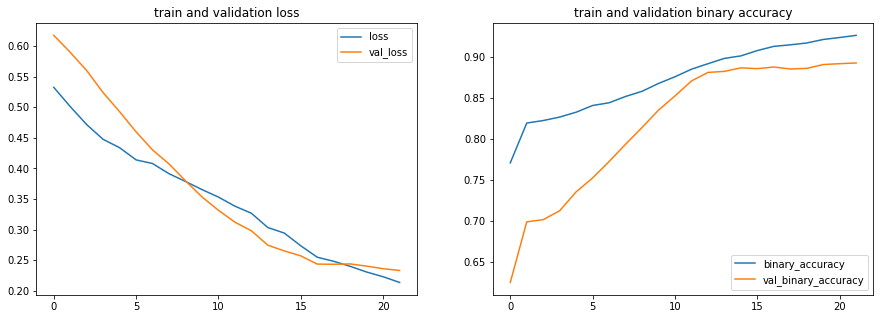

In [ ]:
# plot loss and accuracy
plot_history(history)

## Test and evaluate our model

In [ ]:
def show_predictions(raw, gt, pred, other_lables):
    
    thresh = 0.5
    max_values = np.max(pred[:,0], axis=(1, 2))
    if np.any(max_values < thresh):
        print("Heads up: If prediction is below {} then the prediction map is shown.".format(thresh))
        print("Max predictions: {}".format(max_values))
    
    num_samples = pred.shape[0]
    fig, ax = plt.subplots(num_samples, 4, sharex=True, sharey=True, figsize=(12, num_samples * 4))
    for i in range(num_samples):
        ax[i, 0].imshow(raw[i,0], aspect="auto")
        ax[i, 1].imshow(gt[i,0], aspect="auto")
        # check for prediction threshold
        if np.sum(max_values[i]) < thresh:
            ax[i, 2].imshow(pred[i,0], aspect="auto")
        else:
            ax[i, 2].imshow(pred[i,0] >= thresh, aspect="auto")
        ax[i, 3].imshow(other_lables[i][0,0].cpu().detach().numpy(), aspect="auto")

    ax[0, 0].set_title("Input")
    ax[0, 1].set_title("Ground truth")
    ax[0, 2].set_title("Prediction")
    ax[0, 3].set_title("GT vom test_loader")
    fig.tight_layout()

Accuracy: 0.922


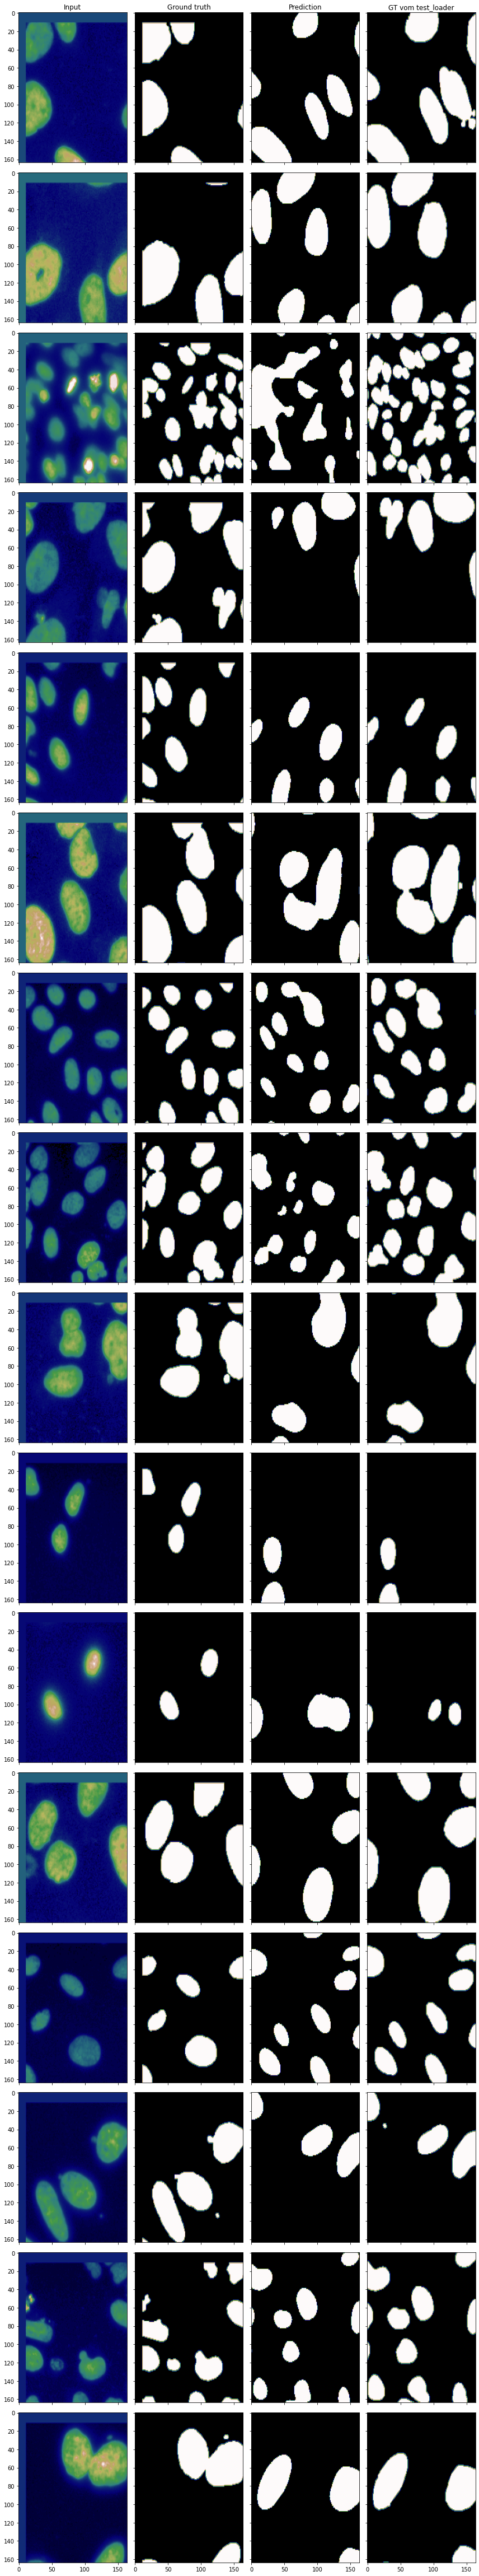

In [ ]:
calc_accuracy_print_img = False
# predict the test set
def predict(net, test_loader):
    net.eval()
    predictions = []
    acc_accuracy = []
    lables = [] # Degug
    output_slices = None
    for image, label in test_loader:
        # get cropping slices for label
        if output_slices is None:
            rand_tensor = torch.rand(image.shape).to(device)
            net_output_shape = net(rand_tensor).shape
            output_slices = get_cropping(label.shape, net_output_shape)
        image = image.to(device)
        label = label[output_slices]
        label = label.to(device)
        pred = net(image)
        pred = activation(pred)
        accuracy = calc_accuracy(pred, label)
        acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        image = np.squeeze(image.cpu())
        pred = np.squeeze(pred.cpu().detach().numpy(),0)
        predictions.append(pred)
        lables.append(label)
    return predictions, float(np.mean(acc_accuracy)), lables
    
# plot predicted results
predictions, mean_accuracy, lables = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(mean_accuracy))

x_test = []
y_test = []
for tmp_x, tmp_y in data_test:
    x_test.append(tmp_x)
    y_test.append(tmp_y)
x_test = np.expand_dims(np.concatenate(x_test), axis=1)
y_test = np.expand_dims(np.concatenate(y_test), axis=1)

show_predictions(x_test, y_test, predictions, lables)

The training of the networks depend on many hyperparameters such as
- network architecture: #layers, #fmaps
- batch size, learning rate
- number and distribution of the training samples

You can play and see how these settings influence the learning curve.

![image.png](https://drive.google.com/uc?export=view&id=18KqN2SHcjVk0EhQtG7JI8SerbpMtBldZ)

# todo: (Effective) Receptive Field of View

The number of convolutions and the depth of the U-Net are the major factors in determining the 
receptive field of the network. The term is borrowed from biology where it describes the "portion of sensory space that can elicit neuronal responses when stimulated" (wikipedia). Each output pixel can look at/depends on an input patch with that diameter centered at its position.
Based on this patch, the network has to be able to make a decision about the prediction for the respective pixel.
Yet larger sizes increase the computation time significantly.

This paper gives a short introduction into the computation: [What are the Receptive, Effective Receptive, and Projective Fields of Neurons in Convolutional Neural Networks?](https://arxiv.org/pdf/1705.07049.pdf).

For more detail you can look into [Computing Receptive Fields of Convolutional Neural Networks](https://distill.pub/2019/computing-receptive-fields/).

The effective receptive field of your network depends on the kind and number of layers.
Some layers have no impact on it, e.g. ReLu as it only works on individual pixels.
Some layers have a one-time effect on it, e.g. convolutional layers, as they work on a local patch of pixels.
A convolutional kernel with a size of 3 looks at the pixel itself and the direct neighbor on each side, it thus increases the receptive field by 2 (per dimension).
Some layers have a permanent effect on it, e.g. pooling. For example, 2x max-pooling (with a stride of two) reduces the image size by a factor of two and selects the maximum value of each block of size 2.
However, all following convolutional layers now operate on the pooled features.
Thus the pixels the kernel covers each correspond to two pixels from before the pooling layer.
A convolutional kernel with size 3 thus increases the receptive field not by 2 but by 2 * size of pooling layer * number of pooling layers before it.

Think about how the other layers in your network influence the field of view of your network.

Define a function to compute the receptive field of your U-Net.
Plot it onto one of the images from the datasets.

In [ ]:
def plot_receptive_field(image, fov):
    image = np.squeeze(image)
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    xmin = image.shape[1]/2 - fov/2
    xmax = image.shape[1]/2 + fov/2
    ymin = image.shape[1]/2 - fov/2
    ymax = image.shape[1]/2 + fov/2
    plt.hlines(ymin, xmin, xmax, color="magenta", lw=3)
    plt.hlines(ymax, xmin, xmax, color="magenta", lw=3)
    plt.vlines(xmin, ymin, ymax, color="magenta", lw=3)
    plt.vlines(xmax, ymin, ymax, color="magenta", lw=3)
    plt.show()

155


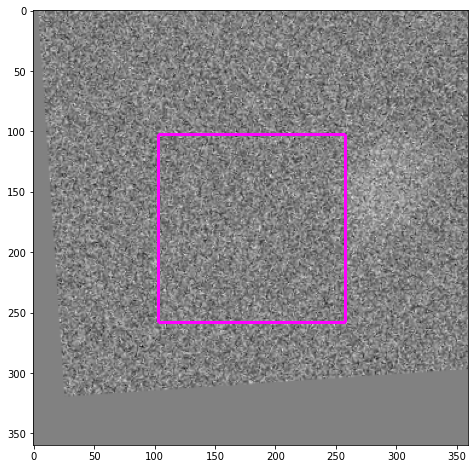

In [ ]:
inputs, labels = dataiter.next()

###########################################################################
# TODO: Add a function to your U-Net class to compute its receptive field #
# then call it here to visualize it on an example image                   #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

fov = net[0].calcRespectiveField()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
print(fov)
plot_receptive_field(inputs, fov)

## Question 1
Compute and plot the receptive field for multiple different U-Net sizes.  
Hypothesize shortly what receptive field sizes might make sense for the kaggle nuclei dataset and why?  
(The important part here is to think about it and come up with arguments for your theories.  
You get points even if your ideas don't apply in this case)  

################ START OF YOUR TEXT ################

It should have a receptive field that is about double so big as the cells to detect. So a pixal can see the whole cell even if it is only on the edge of the cell. Also Pixels in the middle can seee enough of the noise on the outside of the cell, to tell cell and noise apart.

################ END OF YOUR TEXT ################



# Instance Segmentation

So far we were only interested in classes, what is background and foreground, 
where are cells or person vs car. But in many cases we not only want to know
if a certain pixel belongs to a cell, but also to which cell.

For isolated objects, this is trivial, all connected foreground pixels form
one instance, yet often instances are very close together or even overlapping.
Then we need to think a bit more how to formulate the loss for our network
and how to extract the instances from the predictions.

Loss
-------
There are many different approaches to instance segmentation.
We will introduce three basic methods:

### Three-class model ###
This is an extension of the basic foreground/background (or two-class) model.
In addition a third class is introduced: the boundary.
Even if two instances are touching, there is a boundary between them. This way they can be separated. 
Instead of a single output (where an output of zero is one class and of one is the other class), the network outputs three values, one per class. And the loss function changes from binary to (sparse) categorical cross entropy.

![three_class.png](https://drive.google.com/uc?export=view&id=1ORZTlHXJHKNFLf9U-PVraCNKLLgD-UON)

### Distance Transform ###
The label for each pixel is the distance to the closest boundary. 
The value within instances is negative and outside of instances is positive.
As the output is not a probability but an (in principle) unbounded scalar, the mean squared error loss function is used.

![sdt.png](https://drive.google.com/uc?export=view&id=1NucFhe9qWvj26A7R7BUQhCFsktDIZrYF)


### Edge Affinities ###
Here we consider not just the pixel but also its direct neighbors (in 2D the left neighbor and the upper neighbor are sufficient, right and down are redundant with the next pixel's left and upper neighbor).
Imagine there is an edge between two pixels if they are in the same class and no edge if not. If we then take all pixels that are directly and indirectly connected by edges, we get an instance. The network predicts the probability that there is an edge, this is called affinity.
As we are considering two neighbors per pixel, our network needs two outputs and as the output is a probability, we are using binary cross entropy

![affinities.png](https://drive.google.com/uc?export=view&id=1qRxqyFLmVqDx4EP4aQPaJbLZKsaV5OLq)

### Metric Learning ###
In metric learning your model learns to predict an embedding vector for each pixel. These embedding vectors are learned such that vectors from pixels belonging to the same instance are similar to each other and dissimilar to the embedding vectors of other instances and the background. It can also be thought of as learning a false coloring where each instance is colored with a unique but arbitrary color.  
![metric_learning.png](https://drive.google.com/uc?export=view&id=1ynjUUcsnADX2VltNg26RtQzLYl7S0cDQ)



## todo: Define activation and loss functions
We have 5 types of labels, corresponding to 5 **prediction_types** below.

For each case, we should define the corresponding output channel numbers, final activation layer, criterion(loss function) and dtye(the data type of the label).It would be clear to fill in these conditions after you look through the part of code about how we define training process.

Please fill in the missing code and uncomment one of the **prediction_type** to start your training. Please consider the discriminative loss from utils for the metric learning approach.

In [ ]:
from utils.disc_loss import DiscriminativeLoss

###########################################################################
# TODO: Uncomment the prediction_type (and corresponding conditions)      #
#       you would like to use for this exercice                           #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# Uncomment to choose one

#prediction_type = "two_class" # same as fg/bg
#prediction_type = "three_class"
#prediction_type = "affinities"
prediction_type = "sdt"
#prediction_type = "metric_learning"

if prediction_type == "two_class":
    out_channels = 2
    activation = torch.nn.Sigmoid()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    dtype = torch.FloatTensor
elif prediction_type == "affinities":
    out_channels = 2 # prop left edge and prop upper edge
    activation = torch.nn.Sigmoid()
    loss_fn = torch.nn.CrossEntropyLoss()
    dtype = torch.FloatTensor
elif prediction_type == "sdt":
    out_channels =1
    activation = torch.nn.Tanh()
    loss_fn = torch.nn.MSELoss()
    dtype = torch.FloatTensor
elif prediction_type == "three_class":
    out_channels = 3
    activation = torch.nn.Sigmoid()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    dtype = torch.FloatTensor
elif prediction_type == "metric_learning":
    out_channels = 32 # size of embading factor, was not give, so set by estimate
    activation = torch.nn.Identity()
    loss_fn = DiscriminativeLoss(device)
    dtype = torch.FloatTensor
else:
    raise RuntimeError("invalid prediction type")
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

Create our input datasets, ground truth labels are chosen depending on the type:

In [ ]:
# make datasets
dataset = "dsb2018"
padding_size = 12  # you might need to change this, e.g. 10 for valid padding, 12 for same padding
batch_size = 4

data_train = KaggleDSB_dataset(dataset, "train", prediction_type=prediction_type, padding_size=padding_size)
data_val = KaggleDSB_dataset(dataset, "val", prediction_type=prediction_type, padding_size=padding_size)
data_test = KaggleDSB_dataset(dataset, "test", prediction_type=prediction_type, padding_size=padding_size)
# make dataloaders
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

Let's have a look at some of the raw data and labels:


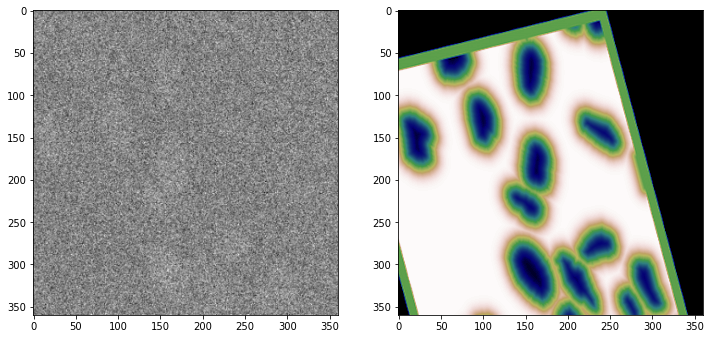

In [ ]:
# repeatedly execute this cell to get different images
for image, label in data_train:
    break

label = np.squeeze(label, 0)
if prediction_type == "affinities":
    label = label[0] + label[1]

fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(label), cmap='gist_earth')
plt.show()

##todo: Define our U-Net

As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.

In [ ]:
torch.manual_seed(42)

###########################################################################
# TODO: Define the net and uncomment the following code                   #
# Please define a UNet which use same padding                             #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

d_factors = [[2,2],[2,2],[2,2],[2,2]]
net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same', # 'valid' or 'same'
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
summary(net, (1, 384, 384)) # e.g. (1, 380, 380) for valid padding, (1, 384, 384) for same padding

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 382, 382]             120
              ReLU-2         [-1, 12, 382, 382]               0
            Conv2d-3         [-1, 12, 380, 380]           1,308
              ReLU-4         [-1, 12, 380, 380]               0
         MultiConv-5         [-1, 12, 380, 380]               0
         MaxPool2d-6         [-1, 12, 190, 190]               0
            Conv2d-7         [-1, 24, 188, 188]           2,616
              ReLU-8         [-1, 24, 188, 188]               0
            Conv2d-9         [-1, 24, 186, 186]           5,208
             ReLU-10         [-1, 24, 186, 186]               0
        MultiConv-11         [-1, 24, 186, 186]               0
        MaxPool2d-12           [-1, 24, 93, 93]               0
           Conv2d-13           [-1, 48, 91, 91]          10,416
             ReLU-14           [-1, 48,

## todo: Training

Before we start training, we have to compile the network and set the optimizer (try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look into networks computational graph and the weights and metrics over time.

In [ ]:
def training_step(model, loss_fn, optimizer, feature, label, prediction_type):
    # speedup version of setting gradients to zero
    for param in model.parameters():
        param.grad = None
    # forward
    logits = model(feature) # B x C x H x W
    shape_dif = np.array(label.shape[-2:]) - np.array(logits.shape[-2:])
    if np.sum(shape_dif)>0:
        label = label[:,:,shape_dif[0]//2:-shape_dif[0]//2,shape_dif[0]//2:-shape_dif[0]//2]        
    if prediction_type == "three_class":
        label=torch.squeeze(label,1) #label.shape=[N,H,W]
    loss_value = loss_fn(input=logits, target=label)  #logits.shape=[N,C,H,W] label.shape=[N,H,W]
    # backward if training mode
    if net.training:
        loss_value.backward()
        optimizer.step()
    if activation is not None:
        output = activation(logits)
    else:
        output = logits
    outputs = {
        'pred': output,
        'logits': logits,
    }
    return loss_value, outputs

In [2]:
training_steps = 2000 # change to whatever works for you
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
###########################################################################
# TODO: put the model and the loss function to device and define the      #
# optimizer with its learning rate                                        #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

net.to(device)
loss_fn.to(device)
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

training_steps = 100

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

NameError: name 'datetime' is not defined

In [66]:
# set flags
net.train() 
loss_fn.train()
step = 0

# this might take ~10 ish minutes
with tqdm(total=training_steps) as pbar:
    while step < training_steps:
        # reset data loader to get random augmentations
        np.random.seed()
        tmp_loader = iter(train_loader)
        for feature, label in tmp_loader:
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, pred = training_step(net, loss_fn, optimizer, feature, label, prediction_type)
            writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
            step += 1
            pbar.update(1)
            if step % 100 == 0:
                net.eval()
                tmp_val_loader = iter(val_loader)
                acc_loss = []
                for feature, label in tmp_val_loader:                    
                    label = label.type(dtype)
                    label = label.to(device)
                    feature = feature.to(device)
                    loss_value, _ = training_step(net, loss_fn, optimizer, feature, label, prediction_type)
                    acc_loss.append(loss_value.cpu().detach().numpy())
                writer.add_scalar('val_loss',np.mean(acc_loss),step)
                net.train()
# todo: save model ...

  0%|          | 0/2000 [00:00<?, ?it/s]

In [67]:
%reload_ext tensorboard
%tensorboard --logdir logs

#or run:
# !tensorboard --logdir=runs 
#to view in separate window

Reusing TensorBoard on port 6006 (pid 8120), started 0:17:13 ago. (Use '!kill 8120' to kill it.)

## Postprocessing

In contrast to the semantic segmentation the postprocessing to extract the final segmentation is a bit more involved and consists of x steps for the two class, three class, sdt and affinity models:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground.
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

For the metric learning model, the post-processing is a bit different. The embeddings are clustered with the mean shift algorithm and the clusters are numbered. You can think of this as clustering pixels by their color, such that the pixels that belong to one uniquely colored instance end up in one cluster and get the same number assigned. 

In [1]:
%reload_ext autoreload
%autoreload 2
from utils.label import *
from utils.evaluate import *

# set flag
net.eval()
# set hyperparameters
# thresholds have to be tuned after training on the validation set
if prediction_type == "two_class":
    fg_thresh = 0.7
    seed_thresh = 0.8
elif prediction_type == "three_class":
    fg_thresh = 0.5
    seed_thresh = 0.6
elif prediction_type == "sdt":
    fg_thresh = 0.0
    seed_thresh = -0.12
elif prediction_type == "affinities":
    fg_thresh = 0.9
    seed_thresh = 0.99
elif prediction_type == "metric_learning":
    fg_thresh = 0.5
    seed_thresh = None
    
def unpad(pred, padding_size):
    return pred[padding_size:-padding_size,padding_size:-padding_size]

avg = 0.0

input_size = None
output_size = None
pad_top_left = None

for idx, (image, gt_labels) in enumerate(test_loader):
    # get network output size
    if output_size is None:
      input_size = image.shape # [-2:]
      rand_tensor = torch.rand(image.shape).to(device)
      output_size = net(rand_tensor).shape
      pad_top_left = (input_size[2] - output_size[2]) // 2  # assume size with shape B x C x H x W
    
    image = image.to(device)
    if pad_top_left == 0:
        pred = net(image)
    else:
      # use tile-and-stitch if valid padding
      image_padded = F.pad(image, (pad_top_left, 300, pad_top_left, 300))
      B, C, H, W = image.shape
      patched_pred = torch.zeros(B, output_size[1], image.shape[2] + 200, image.shape[3] + 200)
      for h in range(0, H, output_size[2]):
          for w in range(0, W, output_size[3]):
              image_tmp = image_padded[:, :, h:h+input_size[2], w:w+input_size[3]]
              pred = net(image_tmp)
              patched_pred[:, :, h:h+pred.shape[2], w:w+pred.shape[3]] = pred
      pred = patched_pred[:,:, 0:input_size[2], 0:input_size[3]]
    
    image = np.squeeze(image.cpu())
    gt_labels = np.squeeze(gt_labels)
    pred = np.squeeze(pred.cpu().detach().numpy(), 0)
    if padding_size and padding_size > 0:
        pred = unpad(np.transpose(pred,(1,2,0)), padding_size)
        pred = np.transpose(pred,(2,0,1))
    if prediction_type == "affinities":
        gt_labels = gt_labels[0] + gt_labels[1]
    
    labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
    ap, precision, recall, tp, fp, fn = evaluate(labelling, data_test.get_filename(idx))
    avg += ap
    print(np.min(surface), np.max(surface))
    labelling = labelling.astype(np.uint8)
    print("average precision: {}, precision: {}, recall: {}".format(ap, precision, recall))
    print("true positives: {}, false positives: {}, false negatives: {}".format(tp, fp, fn))
    if prediction_type == "metric_learning":
        surface = surface + np.abs(np.min(surface, axis=(1,2)))[:,np.newaxis,np.newaxis]
        surface /= np.max(surface, axis=(1,2))[:, np.newaxis, np.newaxis]
        surface = np.transpose(surface, (1,2,0))

    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
   
    image=unpad(image,(image.shape[-1]-labelling.shape[-1])//2)
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    gt_labels=unpad(gt_labels,(gt_labels.shape[-1]-labelling.shape[-1])//2)
    plt.imshow(np.squeeze(1.0-gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(1.0-surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap, interpolation="none")

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))

NameError: name 'net' is not defined

## todo: Class-intern benchmark
Try different methods, hyperparameters, and see how you can improve your results. Write down your best average precision on the test set with the corresponding network settings.


################ START OF YOUR TEXT ################

################ END OF YOUR TEXT ################

## Question 2 

Do you have further ideas how to improve our instance segmentation approach (e.g. with changes regarding to architecture, loss, etc.)?


################ START OF YOUR TEXT ################

################ END OF YOUR TEXT ################